# FM 广告点击率预测

FM算法全称为因子分解机 (FactorizationMachine)。

它是广告和推荐领域非常著名的算法，在线性回归模型上考虑了特征的二阶交互。

适合捕捉大规模稀疏特征(类别特征)当中的特征交互。


本范例演示继承 torchkeras.tabular.models.BaseModel 构建FM模型 进行广告点击率预测。

有关FM模型的理论介绍，参考如下eat_pytorch_in_20_days中的讲解教程：

https://github.com/lyhue1991/eat_pytorch_in_20_days/blob/master/7-3%2CFM%E6%A8%A1%E5%9E%8B.ipynb


公众号**算法美食屋**后台回复关键词：torchkeras，获取本文notebook源码和所用criteo_small数据集下载链接。


In [8]:
import sys
sys.path.append('..')


## 一，准备数据

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

np.random.seed(42)


In [5]:
from sklearn.preprocessing import LabelEncoder

dfdata = pd.read_csv('criteo_small.zip',sep='\t',header=None)
dfdata.columns = ["label"] + ["I"+str(x) for x in range(1,14)] + [
    "C"+str(x) for x in range(14,40)]

target_col = 'label'
cat_cols = [x for x in dfdata.columns if x.startswith('C')]
num_cols = [x for x in dfdata.columns if x.startswith('I')]


In [6]:
dftrain_val,dftest_raw = train_test_split(dfdata,test_size=0.2,random_state=42)
dftrain_raw,dfval_raw = train_test_split(dftrain_val,test_size=0.2,random_state=42)


In [9]:
from torchkeras.tabular import TabularPreprocessor
from sklearn.preprocessing import OrdinalEncoder

#特征工程
pipe = TabularPreprocessor(cat_features = cat_cols, onehot_max_cat_num=3)
encoder = OrdinalEncoder()

dftrain = pipe.fit_transform(dftrain_raw.drop(target_col,axis=1))
dftrain[target_col] = encoder.fit_transform(
    dftrain_raw[target_col].values.reshape(-1,1)).astype(np.int32)

dfval = pipe.transform(dfval_raw.drop(target_col,axis=1))
dfval[target_col] = encoder.transform(
    dfval_raw[target_col].values.reshape(-1,1)).astype(np.int32)

dftest = pipe.transform(dftest_raw.drop(target_col,axis=1))
dftest[target_col] = encoder.transform(
    dftest_raw[target_col].values.reshape(-1,1)).astype(np.int32)



  0%|          | 0/24 [00:00<?, ?it/s]

In [10]:
from torchkeras.tabular import TabularDataset
from torch.utils.data import Dataset,DataLoader 

def get_dataset(dfdata):
    return TabularDataset(
                data = dfdata,
                task = 'binary',
                target = [target_col],
                continuous_cols = pipe.get_numeric_features(),
                categorical_cols = pipe.get_embedding_features()
        )

def get_dataloader(ds,batch_size=512,num_workers=0,shuffle=False):
    dl = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=False,
        )
    return dl 
    
ds_train = get_dataset(dftrain)
ds_val = get_dataset(dfval)
ds_test = get_dataset(dftest)

dl_train = get_dataloader(ds_train,shuffle=True)
dl_val = get_dataloader(ds_val,shuffle=False)
dl_test = get_dataloader(ds_test,shuffle=False)



In [11]:
for batch in dl_train:
    break

In [12]:
dftrain.shape 

(640000, 45)

## 二，定义模型

In [13]:
from dataclasses import dataclass, field
from typing import Optional
from torchkeras.tabular.models import BaseModel


from torchkeras.tabular.config import ModelConfig

@dataclass
class FMConfig(ModelConfig):
    input_embed_dim: int = field(
        default=32,
        metadata={"help": "The embedding dimension for the input categorical features. Defaults to 32"},
    )
    
    embedding_initialization: Optional[str] = field(
        default="kaiming_uniform",
        metadata={
            "help": "Initialization scheme for the embedding layers. Defaults to `kaiming`",
            "choices": ["kaiming_uniform", "kaiming_normal"],
        }
    )
    

In [17]:
import torch 
from torch import nn
from torch import nn,Tensor 
import torch.nn.functional as F 

from omegaconf import DictConfig
from typing import Dict,Any
from torchkeras.tabular.models import BaseModel

class NumEmbedding(nn.Module):
    """
    连续特征用linear层编码
    输入shape: [batch_size,features_num(n), d_in], # d_in 通常是1
    输出shape: [batch_size,features_num(n), d_out]
    """
    
    def __init__(self, n: int, d_in: int, d_out: int, bias: bool = False) -> None:
        super().__init__()
        self.weight = nn.Parameter(Tensor(n, d_in, d_out))
        self.bias = nn.Parameter(Tensor(n, d_out)) if bias else None
        with torch.no_grad():
            for i in range(n):
                layer = nn.Linear(d_in, d_out)
                self.weight[i] = layer.weight.T
                if self.bias is not None:
                    self.bias[i] = layer.bias

    def forward(self, x_num):
        # x_num: batch_size, features_num, d_in
        assert x_num.ndim == 3
        x = x_num[..., None] * self.weight[None]
        x = x.sum(-2)
        #x = torch.einsum("bfi,fij->bfj",x_num,self.weight)
        if self.bias is not None:
            x = x + self.bias[None]
        return x
    
class CatEmbedding(nn.Module):
    """
    离散特征用Embedding层编码
    输入shape: [batch_size,features_num], 
    输出shape: [batch_size,features_num, d_embed]
    """
    def __init__(self, categories, d_embed):
        super().__init__()
        self.embedding = nn.Embedding(sum(categories), d_embed)
        self.offsets = nn.Parameter(
                torch.tensor([0] + categories[:-1]).cumsum(0),requires_grad=False)
        
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x_cat):
        """
        :param x_cat: Long tensor of size ``(batch_size, features_num)``
        """
        x = x_cat + self.offsets[None]
        return self.embedding(x) 
    
class CatLinear(nn.Module):
    """
    离散特征用Embedding实现线性层（等价于先F.onehot再nn.Linear()）
    输入shape: [batch_size,features_num], 
    输出shape: [batch_size,d_out]
    """
    def __init__(self, categories, d_out=1):
        super().__init__()
        self.fc = nn.Embedding(sum(categories), d_out)
        self.bias = nn.Parameter(torch.zeros((d_out,)))
        self.offsets = nn.Parameter(
                torch.tensor([0] + categories[:-1]).cumsum(0),requires_grad=False)

    def forward(self, x_cat):
        """
        :param x: Long tensor of size ``(batch_size, features_num)``
        """
        x = x_cat + self.offsets[None]
        return torch.sum(self.fc(x), dim=1) + self.bias 
    
    
class FMLayer(nn.Module):
    """
    FM交互项
    """

    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x): #注意：这里的x是公式中的 <v_i> * xi
        """
        :param x: Float tensor of size ``(batch_size, num_features, k)``
        """
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix



class FMBackbone(nn.Module):
    def __init__(self, config: DictConfig, **kwargs):
        super().__init__()
        self.hparams = config
        d_numerical = self.hparams.continuous_dim
        d_embed = self.hparams.input_embed_dim
        
        categories = self.hparams.categorical_cardinality
        n_classes = self.hparams.output_dim 
        
        self.num_linear = nn.Linear(d_numerical,n_classes) if d_numerical else None
        self.cat_linear = CatLinear(categories,n_classes) if categories else None
        
        self.num_embedding = NumEmbedding(d_numerical,1, d_embed) if d_numerical else None
        self.cat_embedding = CatEmbedding(categories, d_embed) if categories else None

        self.fm = FMLayer(reduce_sum=False)
        self.fm_linear = nn.Linear(d_embed,n_classes)
        

    def forward(self, x: Dict):
        
        x_cat,x_num = x["categorical"], x["continuous"]
        
    
        #linear部分
        x = 0.0
        if self.num_linear:
            x = x + self.num_linear(x_num) 
        if self.cat_linear:
            x = x + self.cat_linear(x_cat)
        
        #交叉项部分
        x_embedding = []
        if self.num_embedding:
            x_embedding.append(self.num_embedding(x_num[...,None]))
        if self.cat_embedding:
            x_embedding.append(self.cat_embedding(x_cat))
        x_embedding = torch.cat(x_embedding,dim=1)

        x = x + self.fm_linear(self.fm(x_embedding)) 
        
        return x


class FMModel(BaseModel):
    def __init__(self, config: DictConfig, **kwargs):
        super().__init__(config, **kwargs)

    @property
    def backbone(self):
        return self._backbone

    @property
    def embedding_layer(self):
        return self._embedding_layer

    @property
    def head(self):
        return self._head
        
    def _build_network(self):
        self._embedding_layer = nn.Identity()
        self._backbone = FMBackbone(self.hparams)
        setattr(self.backbone, "output_dim", self.hparams.output_dim)
        self._head = nn.Identity()
        
    def forward(self, x: Dict) -> Dict[str, Any]:
        x = self.embed_input(x)
        x = self.compute_backbone(x)
        return self.compute_head(x)

    def extract_embedding(self):
        raise ValueError("Extracting Embeddings is not supported by FMModel.")


In [18]:
model_config = FMConfig(
    task="binary"
)
config = model_config.merge_dataset_config(ds_train)

print('input_embed_dim = ', config.input_embed_dim)
print('\n categorical_cardinality = ',config.categorical_cardinality)
print('\n embedding_dims = ' , config.embedding_dims)


input_embed_dim =  32

 categorical_cardinality =  [1000, 529, 1000, 1000, 246, 15, 1000, 502, 1000, 1000, 1000, 1000, 26, 1000, 1000, 10, 1000, 1000, 1000, 16, 15, 1000, 63, 1000]

 embedding_dims =  [[1000, 50], [529, 50], [1000, 50], [1000, 50], [246, 50], [15, 8], [1000, 50], [502, 50], [1000, 50], [1000, 50], [1000, 50], [1000, 50], [26, 13], [1000, 50], [1000, 50], [10, 5], [1000, 50], [1000, 50], [1000, 50], [16, 8], [15, 8], [1000, 50], [63, 32], [1000, 50]]


In [19]:
net = FMModel(config = config)

#初始化参数
net.reset_weights()
net.data_aware_initialization(dl_train)


#默认输出head是一个多分类, 2个输出
print(net.backbone.output_dim)
print(net.hparams.output_dim)


1
1


In [20]:
for batch in dl_train:
    break 

In [21]:
output = net.forward(batch)
loss = net.compute_loss(output,batch['target'])
print(loss)

tensor(4.5928, grad_fn=<AddBackward0>)


## 三，训练模型

In [22]:
from torchkeras import KerasModel 
from torchkeras.tabular import StepRunner 
KerasModel.StepRunner = StepRunner 

import torch 
from torchkeras.metrics import AUC 

optimizer = torch.optim.AdamW(net.parameters(),lr = 1e-3)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, 
#                                                steps_per_epoch=len(dl_train), epochs=20)

keras_model = KerasModel(net,
                   loss_fn=None,
                   optimizer = optimizer,
                   metrics_dict = {'auc':AUC()}
                   )


<<<<<< 🚀 mps is used >>>>>>


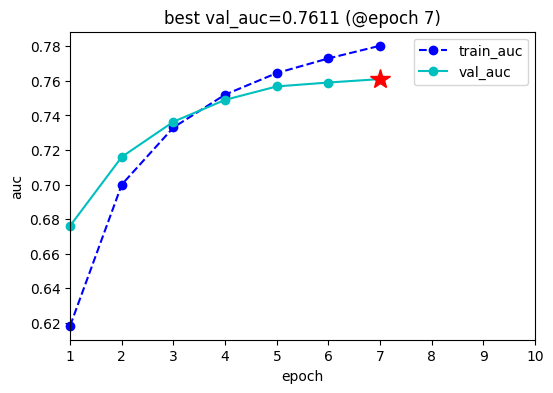

In [ ]:
keras_model.fit(
    train_data = dl_train,
    val_data= dl_val,
    ckpt_path='checkpoint',
    epochs=30,
    patience=5,
    monitor="val_auc", 
    mode="max",
    plot = True,
    wandb = False
)

## 四，评估模型

In [ ]:
keras_model.evaluate(dl_train)

In [ ]:
keras_model.evaluate(dl_val)

In [ ]:
keras_model.evaluate(dl_test)

## 五，使用模型

In [ ]:
from tqdm import tqdm 

net,dl_test = keras_model.accelerator.prepare(net,dl_test)
net.eval()
preds = []
with torch.no_grad():
    for batch in tqdm(dl_test):
        preds.append(net.predict(batch))
    

In [ ]:
yhat_list = [yd.sigmoid().reshape(-1).tolist() for yd in preds]
yhat = []
for yd in yhat_list:
    yhat.extend(yd)

In [ ]:
dftest_raw = dftest_raw.rename(columns = {target_col: 'y'})
dftest_raw['yhat'] = yhat

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(dftest_raw['y'],dftest_raw['yhat'])

## 六，保存模型

最佳模型权重已经保存在ckpt_path = 'checkpoint'位置了。

In [ ]:
net.load_state_dict(torch.load('checkpoint'))